In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import pandas as pd
from tensorflow.keras.applications import ResNet50V2

tf.__version__

'2.3.0-dev20200522'

In [2]:
PATH = 'data'

os.listdir(PATH)

['jpeg224',
 'sample_submission.csv',
 'subset.csv',
 'subset_clean.csv',
 'test.csv',
 'test_clean.csv',
 'train.csv',
 'train_clean.csv',
 'train_clean_split.csv',
 'train_split.csv',
 'val_clean_split.csv',
 'val_split.csv']

In [3]:
train = pd.read_csv(f'{PATH}/train_clean.csv')

train.shape

(33126, 8)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     33126 non-null  object
 1   patient_id                     33126 non-null  object
 2   sex                            33126 non-null  object
 3   age_approx                     33126 non-null  object
 4   anatom_site_general_challenge  33126 non-null  object
 5   diagnosis                      33126 non-null  object
 6   benign_malignant               33126 non-null  object
 7   target                         33126 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


In [5]:
train.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

In [6]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder()
cols = ["sex", "age_approx", "anatom_site_general_challenge"]
oh_encoder.fit(train[cols])
oh_encoder.categories_

[array(['female', 'male', 'unk'], dtype=object),
 array(['0.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
        '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0',
        '85.0', '90.0', 'unk'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unk', 'upper extremity'], dtype=object)]

In [8]:
oh_encoder.transform([["female", "10.0", "upper extremity"]]).toarray()

array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [9]:
#train = pd.read_csv(f'{PATH}/train_clean_split.csv')
train = pd.read_csv(f'{PATH}/subset_clean.csv')
val = pd.read_csv(f'{PATH}/val_clean_split.csv')

train.shape, val.shape

((2220, 8), (10932, 8))

In [10]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

def decode(filename, meta, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return img, meta, label

def augment(img, meta, label):
    # augmentation
    #img = tf.image.flip_left_right(img)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return (img, meta), label

def load_ds(df):
    options = tf.data.Options()
    options.experimental_deterministic = False
    imgs, labels = df["image_name"].values, df["target"].values
    meta = df[cols]
    meta = oh_encoder.transform(meta).toarray()
    imgs = [f'{PATH}/jpeg224/train/{img}.jpg' for img in imgs]
    ds = tf.data.Dataset.from_tensor_slices((imgs, meta, labels))
    ds = ds.with_options(options)
    ds = ds.map(decode, num_parallel_calls=AUTO)
    ds = ds.cache()
    ds = ds.map(augment, num_parallel_calls=AUTO)
    ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTO)
    return ds

In [11]:
train_ds = load_ds(train)
val_ds = load_ds(val)

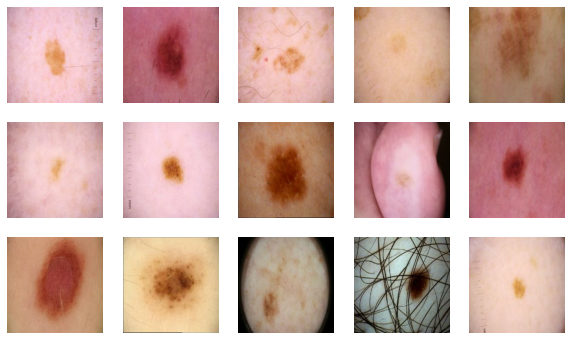

In [12]:
import matplotlib.pyplot as plt
import random

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        for data, labels in train_ds.take(1):
            imgs, meta = data
            img = imgs[0].numpy() / 255
            plt.imshow(img)
            plt.axis(False)
plt.show()

In [13]:
for data, labels in train_ds.take(1):
    imgs, meta = data
    print(meta)

tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(64, 29), dtype=float64)


In [14]:
IMAGE_SIZE = (224, 224, 3)

encoder = ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights='imagenet'
)
encoder.trainable = False

imgs = keras.Input(shape=IMAGE_SIZE, name="image")
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(imgs)
x = encoder(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

metadata = keras.Input(shape=(29,), name="metadata")
y = keras.layers.Dense(100, activation="relu")(metadata)
y = keras.layers.Dense(3, activation="relu")(y)

z = keras.layers.concatenate([x, y])
outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model = keras.Model(inputs=[imgs, metadata], outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
metadata (InputLayer)           [(None, 29)]         0                                            
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 7, 7, 2048)   23564800    rescaling[0][0]                  
_______________________________________________________________________________________

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name="auc")]
)

In [16]:
filepath = './checkpoints/checkpoint'
cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_auc",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

In [17]:
model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    validation_steps=10,
    callbacks=[cb]
)

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.2550 - auc: 0.3784
Epoch 00001: val_auc improved from -inf to 0.38080, saving model to ./checkpoints\checkpoint
35/35 [==============================] - 13s 366ms/step - loss: 0.2550 - auc: 0.3784 - val_loss: 0.1536 - val_auc: 0.3808
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.1070 - auc: 0.4849
Epoch 00002: val_auc improved from 0.38080 to 0.59452, saving model to ./checkpoints\checkpoint
35/35 [==============================] - 11s 316ms/step - loss: 0.1070 - auc: 0.4849 - val_loss: 0.0848 - val_auc: 0.5945
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.0951 - auc: 0.5438
Epoch 00003: val_auc did not improve from 0.59452
35/35 [==============================] - 11s 310ms/step - loss: 0.0951 - auc: 0.5438 - val_loss: 0.0944 - val_auc: 0.5154
Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.0854 - auc: 0.6666
Epoch 00004: val_auc did not improve fr

In [18]:
model.load_weights(filepath)
model.save("model.h5")

In [19]:
model.evaluate(val_ds)

171/171 [==============================] - 40s 233ms/step - loss: 0.0809 - auc: 0.7471


[0.08088665455579758, 0.7470748424530029]

In [20]:
test = pd.read_csv(f'{PATH}/test_clean.csv')
test['age_approx'] = test['age_approx'].astype(str)

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,unk
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     10982 non-null  object
 1   patient_id                     10982 non-null  object
 2   sex                            10982 non-null  object
 3   age_approx                     10982 non-null  object
 4   anatom_site_general_challenge  10982 non-null  object
dtypes: object(5)
memory usage: 429.1+ KB


In [22]:
def decode_test(filename, meta):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return {'image': img, 'metadata': meta}

def load_test_ds(df):
    imgs = df["image_name"].values
    imgs = [f'{PATH}/jpeg224/test/{img}.jpg' for img in imgs]
    meta = df[cols]
    meta = oh_encoder.transform(meta).toarray()
    ds = tf.data.Dataset.from_tensor_slices((imgs, meta))
    ds = ds.map(decode_test)
    ds = ds.batch(BATCH_SIZE)
    return ds

In [23]:
test_ds = load_test_ds(test)

In [24]:
preds = model.predict(test_ds)

In [25]:
preds

array([[0.00831544],
       [0.00425506],
       [0.0129039 ],
       ...,
       [0.04382324],
       [0.00177155],
       [0.11404658]], dtype=float32)

In [26]:
submission = pd.DataFrame({'image_name': test['image_name'].values, 'target': preds.ravel()})

submission

,image_name,target
0,ISIC_0052060,0.008315
1,ISIC_0052349,0.004255
2,ISIC_0058510,0.012904
3,ISIC_0073313,0.001038
4,ISIC_0073502,0.009360
...,...,...
10977,ISIC_9992485,0.014227
10978,ISIC_9996992,0.035775
10979,ISIC_9997917,0.043823
10980,ISIC_9998234,0.001772


In [27]:
submission.to_csv('submission.csv', index=False)